## Sequential-Walsh adjustable: https://arxiv.org/pdf/2304.10460.pdf (modified)

In [11]:
import numpy as np
from qiskit import *
from qiskit.tools.visualization import *
from qiskit.extensions import *
from qiskit import QuantumCircuit, transpile
#from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit.providers.aer import QasmSimulator
from math import factorial, comb

"""Adjustable-depth quantum circuit for diagonal operator"""

def l(k):
    """
    Parameters
    ----------
    k : int
        An index used in the computation of Q10

    Returns
    -------
    int
    """
    if k == 0:
        return 1
    else:
        return 2**(k-1) - 1 + l(k-1)
        
def q0(n,m,i,f):
    """
    Parameters
    ----------
    n : int
        The number of qubits encoding the position
    m : int
        The adjustable-depth parameter
    i : int
        Iteration index of U_i operator
    f : fun

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
        Quantum circuit Q0
    """
    M = 2**m
    q = QuantumRegister(n, name= 'q')
    s = AncillaRegister(M-1, name= 's')
    b = AncillaRegister(M, name= 'b')
    qc = QuantumCircuit(q, s, b)
    # Adding the quantum gates
    for k in range(M):
        current_state = i*M*2 + k*2
        x1 = bin(current_state)[2:].zfill(n)[::-1]
        x2 = bin(current_state + 1)[2:].zfill(n)[::-1]
        dyadic1, dyadic2 = 0, 0
        for j in range(n):
            dyadic1 += int(x1[n-j-1])/2**(j+1)
            dyadic2 += int(x2[n-j-1])/2**(j+1)
        unitary = np.array([[np.exp(1j*f(dyadic1)),0], [0,np.exp(1j*f(dyadic2))]])
        gate = UnitaryGate(unitary, label='C'+str(i*M+k))
        if k == 0:
            qc.append(gate.control(1), [b[k], q[k]])
        else:
            qc.append(gate.control(1), [b[k], s[k-1]])
    return qc
 

def q2(n,m):
    """
    Parameters
    ----------
    n : int
        The number of qubits encoding the position
    m : int
        The adjustable-depth parameter

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
        Quantum circuit Q2
    """
    M = 2**m
    q = QuantumRegister(n, name= 'q')
    s = AncillaRegister(M-1, name= 's')
    b = AncillaRegister(M, name= 'b')
    qc = QuantumCircuit(q, s, b)
    '''
    # for block diagonal unitaries
    # Q20
    for j in range(m-2 +1):
        #qc.barrier()
        for k in range(2**(m-j-1)-2 +1):
            qc.cnot(b[int(2**m -1-2**(j+1)*(1/2 +k))], b[2**m -1-k*2**(j+1)])
    # Q21
    for j in range(m-1+1):
        #qc.barrier()
        for k in range(2**j -1+1):
            if k == 0:
                qc.cswap(b[(k+1)*2**(m-j)-1], q[0], s[int(2**(m-j)*(1/2 +k))-1])
            else:
                qc.cswap(b[(k+1)*2**(m-j)-1], s[k*2**(m-j)-1], s[int(2**(m-j)*(1/2 +k))-1])        
        if j != m-1:
            #qc.barrier()
            for l in range(2**(j+1)-2+1):
                qc.cnot(b[int(2**m -1-2**(m-j-1)*(1/2 +l))], b[2**m -1- l*2**(m-j-1)])
    '''
    for i in range(m):
        for j in range(2**i):
            if j == 0 :
                qc.cnot(q[0],s[2**i-1])
            else:
                qc.cnot(s[j-1],s[j+2**i-1])
    return qc


def q10(n,m):
    """
    Parameters
    ----------
    n : int
        The number of qubits encoding the position
    m : int
        The adjustable-depth parameter

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
        Quantum circuit Q10 used to build Q1
    """
    M = 2**m
    q = QuantumRegister(n, name= 'q')
    s = AncillaRegister(M-1, name= 's')
    b = AncillaRegister(M, name= 'b')
    qc = QuantumCircuit(q, s, b)
    # Adding the quantum gates
    for j in range(m-2 +1):
        #qc.barrier()
        for k in range(j+1,m-1+1):
            if j == 0:
                qc.cnot(q[k+1],s[l(k)-1])
            else:
                qc.cnot(q[k+1],s[l(k)+2**j - 1 - 1])
                for l_prime in range(2**j -2+1):
                    qc.cnot(s[l(k)+l_prime-1],s[l(k)+l_prime+2**j-1])   
    return qc
    
def q11(n,m,i):
    """
    Parameters
    ----------
    n : int
        The number of qubits encoding the position
    m : int
        The adjustable-depth parameter
    i : int
        Iteration index of U_i operator

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
        Quantum circuit Q11 used to build Q1
    """
    M = 2**m
    q = QuantumRegister(n, name= 'q')
    s = AncillaRegister(M-1, name= 's')
    b = AncillaRegister(M, name= 'b')
    qc = QuantumCircuit(q, s, b)
    
    ctrl_qubits = [q[k+1] for k in range(m,n-1)] # called alpha in the paper
    # Bits flips
    for k in range(m,n-1):
        # Function g
        if np.floor((i/2**(k-m)) % 2) == 0:
            qc.x(q[k+1])
    # (n-m)-Toffoli gate
    if m != n-1 :
        qc.mcx(ctrl_qubits,b[0]) # CHANGE WITH THE POLYLOG MULTI CONTROL METHOD
    else:
        qc.x(b[0])    
    # Controlled-swaps
    for j in range(m-1 +1):
        #qc.barrier()
        qc.cswap(q[j+1],b[0],b[2**j])
        for k in range(1,2**j -1 +1):
            qc.cswap(s[j+k-1-1],b[k],b[k+2**j])
    #qc.barrier()     
    return qc
    
def build_u_i(n,m,i,f):
    """
    Parameters
    ----------
    n : int
        The number of qubits encoding the position
    m : int
        The adjustable-depth parameter
    i : int
        Iteration index of U_i operator
    f : fun
    
    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
        Quantum circuit U_i
    """
    M = 2**m
    q = QuantumRegister(n, name= 'q')
    s = AncillaRegister(M-1, name= 's')
    b = AncillaRegister(M, name= 'b')
    qc = QuantumCircuit(q, s, b)
    all_qubits = [i for i in q] + [i for i in s] + [i for i in b]
    # Q1
    qc = qc.compose(q10(n,m),all_qubits)
    qc = qc.compose(q11(n,m,i),all_qubits)
    qc = qc.compose(q10(n,m).inverse(),all_qubits)
    # Q2
    qc = qc.compose(q2(n,m),all_qubits)
    # Q0
    qc = qc.compose(q0(n,m,i,f),all_qubits)
    # Q2_dagger
    qc = qc.compose(q2(n,m).inverse(),all_qubits)
    # Q1_dagger
    qc = qc.compose(q10(n,m),all_qubits)
    qc = qc.compose(q11(n,m,i).inverse(),all_qubits)
    qc = qc.compose(q10(n,m).inverse(),all_qubits)
    return qc
    
def adjustable_depth(n,m,f):
    """
    Parameters
    ----------
    n : int
        The number of qubits encoding the position
    m : int
        The adjustable-depth parameter
    f : fun

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
        Quantum circuit implementing the adjustable-depth diagonal unitary according to function f
    """
    M = 2**m
    q = QuantumRegister(n, name= 'q')
    s = AncillaRegister(M-1, name= 's')
    b = AncillaRegister(M, name= 'b')
    qc = QuantumCircuit(q, s, b)
    all_qubits = [i for i in q] + [i for i in s] + [i for i in b]
    for i in range(2**(n-m-1)):
        qc = qc.compose(build_u_i(n,m,i,f),all_qubits)
    return qc

def adjustable_depth_diagonal(n,m,p,f):
    """
    Parameters
    ----------
    n : int
        The number of qubits encoding the position
    m : int
        The adjustable-depth parameter
    p : int
        The number of working qubits
    f : fun

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
        Quantum circuit implementing the adjustable-depth diagonal unitary according to function f working on
        p qubits
    """
    # m = 0,...,n-p-1
    while m > n-p-1:
        m -= 1
    # p = 0,...,n-1
    if p > n-1:
        print('Wrong value for p')
        return 0
    print('Adjustable-depth(n='+str(n)+',m='+str(m)+',p='+str(p)+')')
    M = 2**m
    q = QuantumRegister(n, name= 'q')
    s = AncillaRegister(M-1, name= 's')
    b = AncillaRegister(M, name= 'b')
    qc = QuantumCircuit(q, s, b)
    qc.h(q)
    adj = adjustable_depth(n-p,m,f)
    all_qubits = [q[0]] + [q[i] for i in range(1,n-p)] + [i for i in s] + [i for i in b]
    qc = qc.compose(adj, all_qubits)
    return qc

def reordering(l,n,p):
    reordered_list = []
    r = 2**(n-p)
    for i in range(r):
        for j in range(2**p):
            reordered_list.append(l[i+j*r])
    return reordered_list

### Matrix representation ###

def diagonal_unitary(n,f):
    diag_unitary = np.identity(2**n,dtype=np.complex128)
    for i in range(2**n):
        x = bin(i)[2:].zfill(n)[::-1]
        dyadic = 0
        for j in range(n):
            dyadic += int(x[n-j-1])/2**(j+1)
        diag_unitary[i][i] = np.exp(1j*f(dyadic))
    return diag_unitary

def hadamard_state(n):
    state = np.ones(2**n,dtype=np.complex128)
    state /= np.linalg.norm(state)
    return state

def fidelity(psi1,psi2,n):
    F = 0+0j
    for i in range(2**n):
        F += np.conj(psi1[i])*psi2[i]
    return(abs(F)**2)

Adjustable-depth(n=3,m=0,p=0)


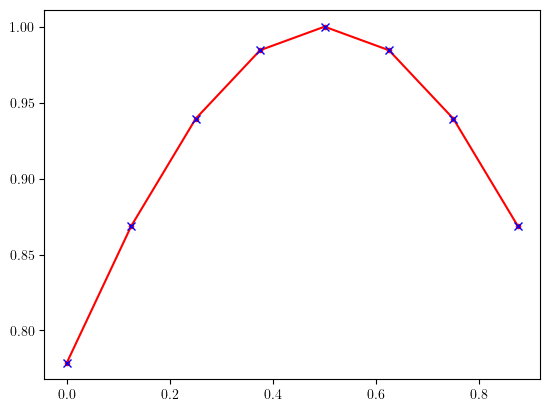

In [12]:
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt

def f(x):
    return np.exp(-(x-1/2)**2)

n = 3
m = 0 # m = 0,...,n-p-1: adjustable-parameter
p = 0 # p = 0,...,n-1: working qubits = n-p

diag = adjustable_depth_diagonal(n,m,p,f)
state = qi.Statevector.from_instruction(diag)

L = np.array(state.data[0:2**n])
L2 = np.angle(L)
newL2 = reordering(L2,n,p)
X = np.array(range(2**n))/2**n

plt.plot(X,newL2,marker='.',c='r')
plt.plot(X,f(X),marker='x',c='b',linestyle='')
plt.show()

## Walsh adjustable

### Walsh diagonal decomposition: https://arxiv.org/pdf/1306.3991.pdf

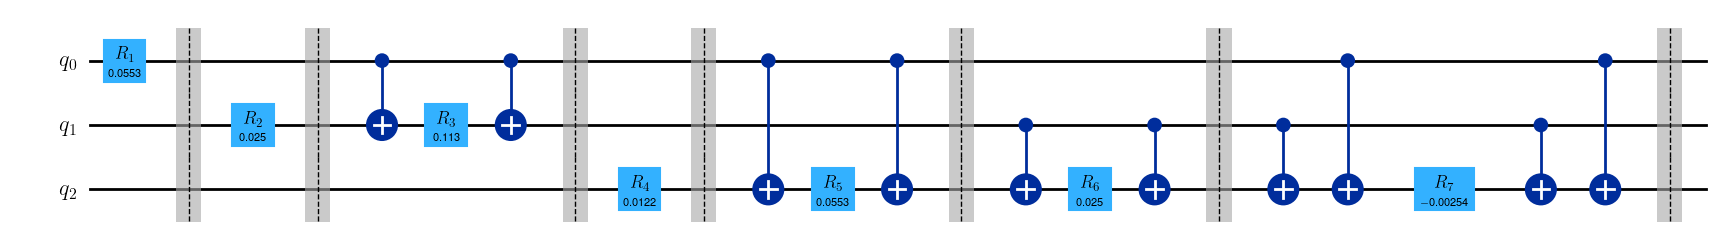

In [13]:
def walsh(j,x): 
    """
    Parameters
    ----------
    j : int
        Order of the Walsh function
    x : float
        real number in [0,1]

    Returns
    -------
    float
        The value of j-th Walsh function at position x
    """
    jbin = bin(j)
    lj = len(jbin)-2
    X = dyatic(x,lj)
    p = 0
    for i in range(lj):
        p += int(int(jbin[-1-i]) * X[i])
    return (-1)**p

def dyatic(x,n):
    """
    Parameters
    ----------
    x : float
        real number in [0,1]
    n : int
        index for the truncation of the dyatic expansion of x

    Returns
    -------
    list
        return the list of coefficient of the dyatic expansion of x up to order n
    """
    l = np.zeros((n))
    a = x
    for i in range(n):
        if a-1/2**(i+1) >= 0:
            l[i]=1
            a = a-1/2**(i+1)
    return l

def walsh_coeff(j,f,N):
    """
    Parameters
    ----------
    j : int
        order of the Walsh coefficient
    f : function
        Function of one variable
    N : int
        integer representing the number of points on which is computed the Walsh coefficient
    Returns
    -------
    float
        j-th Walsh coefficient of the N-th Walsh series of f
    """
    k = np.array(range(N))/N
    a = 0
    for i in range(N):
        a += f(k[i]) * walsh(j,k[i])/N
    return a

def list_walsh_coeff(f,N):
    """
    Parameters
    ----------
    f : function
        Function of one variable.
    N : int
        integer representing the number of points on which is computed the Walsh coefficient.
    Returns
    -------
    list
        list of the Walsh coefficient of the N-th Walsh series of f.
    """
    coeff = []
    for j in range(N):
        coeff.append(walsh_coeff(j,f,N))
    return coeff

def f5(x):
    return np.exp(-(x-0.5)**2)

def circ(n,f):
    walsh_coeff = list_walsh_coeff(f,2**n)
    q = QuantumRegister(n,name='q') # q_0 is the least significant bit
    qc = QuantumCircuit(q)
    for i in range(1,2**n):
        ibin = bin(i)[2:].zfill(n)
        first1bitFound = False
        gate = RZGate(-2*walsh_coeff[i], label='$R_{'+str(i)+'}$')
        first1bitIndex = 0
        cnots = []
        for j, bit in enumerate(ibin):
            if bit == '1':
                if not first1bitFound:
                    first1bitFound = True
                    first1bitIndex = n-j-1 # replace by j if q_{n-1} is the least significant bit
                else:
                    cnots.append(j)
                    qc.cx(q[n-j-1],q[first1bitIndex])
        qc.append(gate,[q[first1bitIndex]])
        for c in cnots:
            qc.cx(q[n-c-1],q[first1bitIndex])
        qc.barrier()
    return qc

def kOneBit(n,k):
    # renvoi le nombre de bitstring sur n bit ayant k bit à 1
    # renvoi le nombre de k-cnots unitary pour q_{n-1}
    if k > n:
        return 0
    else:
        return int(factorial(n)/(factorial(k)*factorial(n-k)))

n = 3
qc = circ(n,f5)
qc.draw('mpl',style='iqp')

### Adjustable version

In [14]:
from itertools import combinations

def binary_to_int(b):
    x = 0
    for i, j in enumerate(b[::-1]):
        x += int(j) * 2**i
    return x
        
def generate_gray_list(my_val):
    """
    Parameters
    ----------
    my_val : int

    Returns
    -------
    List of the first 2**my_val binary numbers in an order such that only one digit differs from one number to the next one.

    """
    if (my_val <= 0):
        return
    my_list = list()
    my_list.append("0")
    my_list.append("1")
    i = 2
    j = 0
    while(True):
        if i >= 1 << my_val:
            break
        for j in range(i - 1, -1, -1):
            my_list.append(my_list[j])
        for j in range(i):
            my_list[j] = "0" + my_list[j]
        for j in range(i, 2 * i):
            my_list[j] = "1" + my_list[j]
        i = i << 1
    return(my_list)

def walsh_operator(order,walsh_coeff):
    """
    Parameters
    ----------
    order : int
        Order of the Walsh operator
    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
        Quantum circuit implementing the Walsh operator of a given order
    """
    binary = bin(order)[2:].zfill(0)[::-1]
    n = len(binary)
    q = QuantumRegister(n,name='q')
    qubits = [qubit for qubit in q]
    qc = QuantumCircuit(q)
    for i in range(n-1):
        if binary[i] == '1':
            qc.cx(q[i],q[n-1])
    qc.append(RZGate(-2*walsh_coeff[order], label='$R_{'+str(order)+'}$'),[q[n-1]])
    for i in range(n-1):
        if binary[i] == '1':
            qc.cx(q[i],q[n-1])                        
    return qc

def get_label(l,k,cnot_index):
    """
    Parameters
    ----------
    l : int
        Index of the qubit
    k : int
        Number of qubit on which the Walsh operator act
    i : int
        i-th Walsh operator acting on k qubits with a rotation on qubit l

    Returns
    -------
    int
        Order of the Walsh operator
    """
    label = 2**l
    for j in cnot_index:
        label += 2**(j-1)
    return label

def couple_of_walsh_operators(l,k,i,walsh_coeffs,cnot_index):
    """
    Parameters
    ----------
    l : int
        Index of the qubit
    k : int
        Number of qubit on which the Walsh operator act
    walsh_coeffs : list
        List of the Walsh coefficients
    cnot_index : list
        List of the index of the control qubits of the CNOTs

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
        Quantum circuit implementing the couple of Walsh operators acting on k and l-k+2 qubits with
        a rotation on qubit |q_l>
        If k == 1 or k == l+1 the circuit returned is not a couple but just the Walsh operators
        that act on k qubits
    """
    q = QuantumRegister(l+1,name='q')
    qc = QuantumCircuit(q)
    qubits = [qubit for qubit in q]
    walsh_label = get_label(l,k,cnot_index[i])
    # extreme blocks
    if k == 1 or k == l+1:
        for j in range(k-1):
            qc.cx(q[cnot_index[i][j]-1],q[l])
        gate = RZGate(-2*walsh_coeffs[walsh_label], label='$R_{'+str(walsh_label)+'}$')
        qc.append(gate,[q[l]])
        for j in range(k-1):
            qc.cx(q[cnot_index[i][j]-1],q[l])
    # parallelizable blocks
    else:
        for j in range(k-1):
            qc.cx(q[cnot_index[i][j]-1],q[l])
        gate1 = RZGate(-2*walsh_coeffs[walsh_label], label='$R_{'+str(walsh_label)+'}$')
        qc.append(gate1,[q[l]])
        for j in range(k-1):
            qc.cx(q[cnot_index[i][j]-1],q[l])
        index = [j for j in range(1,l+1)]
        for j in cnot_index[i]:
            index.remove(j)
        for j in index:
            qc.cx(q[j-1],q[l])
        walsh_label2 = get_label(l,k,index)
        gate2 = RZGate(-2*walsh_coeffs[walsh_label2], label='$R_{'+str(walsh_label2)+'}$')
        qc.append(gate2,[q[l]])
        for j in index:
            qc.cx(q[j-1],q[l]) 
    return qc

def couple_of_walsh_operators_parallelized(l,k,i,walsh_coeffs,cnot_index):
    """
    Parameters
    ----------
    l : int
        Index of the qubit
    k : int
        Number of qubit on which the Walsh operator act
    walsh_coeffs : list
        List of the Walsh coefficients
    cnot_index : list
        List of the index of the control qubits of the CNOTs

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
        Quantum circuit implementing the parallelized couple of Walsh operators acting on k and l-k+2 qubits 
        with a rotation on qubit |q_l>
        If k == 1 or k == l+1 the circuit returned is not a couple but just the Walsh operators
        that act on k qubits
    """
    q = QuantumRegister(l+2,name='q')
    qc = QuantumCircuit(q)
    qubits = [qubit for qubit in q]
    # parallelizable blocks
    #qc.cx(q[l],q[l+1])
    for j in range(k-1):
        qc.cx(q[cnot_index[i][j]-1],q[l])
    walsh_label = get_label(l,k,cnot_index[i])
    gate1 = RZGate(-2*walsh_coeffs[walsh_label], label='$R_{'+str(walsh_label)+'}$')
    qc.append(gate1,[q[l]])
    for j in range(k-1):
        qc.cx(q[cnot_index[i][j]-1],q[l])
    index = [j for j in range(1,l+1)]
    for j in cnot_index[i]:
        index.remove(j)
    for j in index:
        qc.cx(q[j-1],q[l+1])
    walsh_label2 = get_label(l,k,index)
    gate2 = RZGate(-2*walsh_coeffs[walsh_label2], label='$R_{'+str(walsh_label2)+'}$')
    qc.append(gate2,[q[l+1]])
    for j in index:
        qc.cx(q[j-1],q[l+1])
    #qc.cx(q[l],q[l+1])
    return qc

# the basis blocks
def sequence_of_couple_of_walsh_operators(l,k,walsh_coeffs,parallelize=False):
    """
    Parameters
    ----------
    l : int
        Index of the qubit
    k : int
        Number of qubit on which the Walsh operator act
    walsh_coeffs : list
        List of the Walsh coefficients
    parallelize : bool
        True if the couple of Walsh operators that act on k and l-k+2 qubits are parallelized, i.e.
        if 1 ancilla qubit is available

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
        Quantum circuit implementing the sequence of potentially parallelized couples of Walsh operators
        acting on k and l-k+2 qubits with a rotation on qubit |q_l>
        If k == 1 or k == l+1 the circuit returned is not a couple but just the Walsh operators
        that act on k qubits
    """
    n_qubit = l+1
    if parallelize and k != 1 and k != l+1:
        n_qubit += 1
    q = QuantumRegister(n_qubit,name='q')
    qc = QuantumCircuit(q)
    qubits = [qubit for qubit in q]
    cnot_index = list(combinations(np.arange(1,l+1), k-1))    
    number_of_sequence = len(cnot_index) #comb(l,k-1)
    if k == l-k+2 and k != 1 and k != l+1:
        number_of_sequence = int(number_of_sequence/2)
    for i in range(number_of_sequence):
        if parallelize and k != 1 and k != l+1:
            # à mettre pour éviter de faire la copie à chaque séquence
            if i == 0:
                qc.cx(q[l],q[l+1])
            qc.append(couple_of_walsh_operators_parallelized(l,k,i,walsh_coeffs,cnot_index),qubits)
            if i == number_of_sequence-1:
                qc.cx(q[l],q[l+1])
            # remplacer par ça si on veut paralléliser les séquence et donc faire les copies pour chacune
            '''
            qc.cx(q[l],q[l+1])
            qc.append(couple_of_walsh_operators_parallelized(l,k,i,walsh_coeffs,cnot_index),qubits)
            qc.cx(q[l],q[l+1])
            '''
        else:
            qc.append(couple_of_walsh_operators(l,k,i,walsh_coeffs,cnot_index),qubits)
    return qc 

# the full circuit
def walsh_circuit(n,f,parallelize=False):
    """
    Parameters
    ----------
    l : int
        Index of the qubit
    k : int
        Number of qubit on which the Walsh operator act
    walsh_coeffs : list
        List of the Walsh coefficients
    parallelize : bool
        True if the couple of Walsh operators that act on k and l-k+2 qubits are parallelized, i.e.
        if 1 ancilla qubit is available

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
        Quantum circuit implementing Walsh circuit with 1 potential ancilla qubit
    """
    n_qubit = n
    walsh_coeffs = list_walsh_coeff(f,2**n)
    if parallelize:
        n_qubit += 1
    q = QuantumRegister(n_qubit,name='q')
    qc = QuantumCircuit(q)
    
    for i in range(int(n/2)):
        qc.swap(q[i],q[n-i-1])
    qc.h(q)
    # walsh operator of order 0
    qc.p(walsh_coeffs[0],q[0])
    qc.x(q[0])
    qc.p(walsh_coeffs[0],q[0])
    qc.x(q[0])
    
    qubits = [qubit for qubit in q]
    for l in range(n):
        qc.append(sequence_of_couple_of_walsh_operators(l,1,walsh_coeffs,parallelize),qubits[:l+1])
        for k in range(2,int(np.ceil((l-1)/2))+2):
            if parallelize:
                new_qubits = qubits[:l+1]
                new_qubits.append(qubits[-1])
                qc.append(sequence_of_couple_of_walsh_operators(l,k,walsh_coeffs,parallelize),new_qubits)
            else:
                qc.append(sequence_of_couple_of_walsh_operators(l,k,walsh_coeffs,parallelize),qubits[:l+1])
        if l > 0:
            qc.append(sequence_of_couple_of_walsh_operators(l,l+1,walsh_coeffs,parallelize),qubits[:l+1])
        #qc.barrier()
    
    for i in range(int(n/2)):
        qc.swap(q[i],q[n-i-1])
    
    return qc

#walsh_coeffs = list_walsh_coeff(f5,2**n)
#qc = sequence_of_couple_of_walsh_operators(l,k,walsh_coeffs,parallelize=False)
#qc = walsh_circuit(n,f,parallelize=False)
#qc.decompose(reps=2).draw('mpl',style='iqx')

In [ ]:
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt

def f(x):
    return np.exp(-(x-1/2)**2)

n = 4

diag = walsh_circuit(n,f,parallelize=True)

state = qi.Statevector.from_instruction(diag)

L = np.array(state.data[0:2**n])
L2 = np.angle(L)
newL2 = reordering(L2,n,n)
X = np.array(range(2**n))/2**n

plt.plot(X,newL2,marker='.',c='r')
plt.plot(X,f(X),marker='x',c='b',linestyle='')
plt.show()

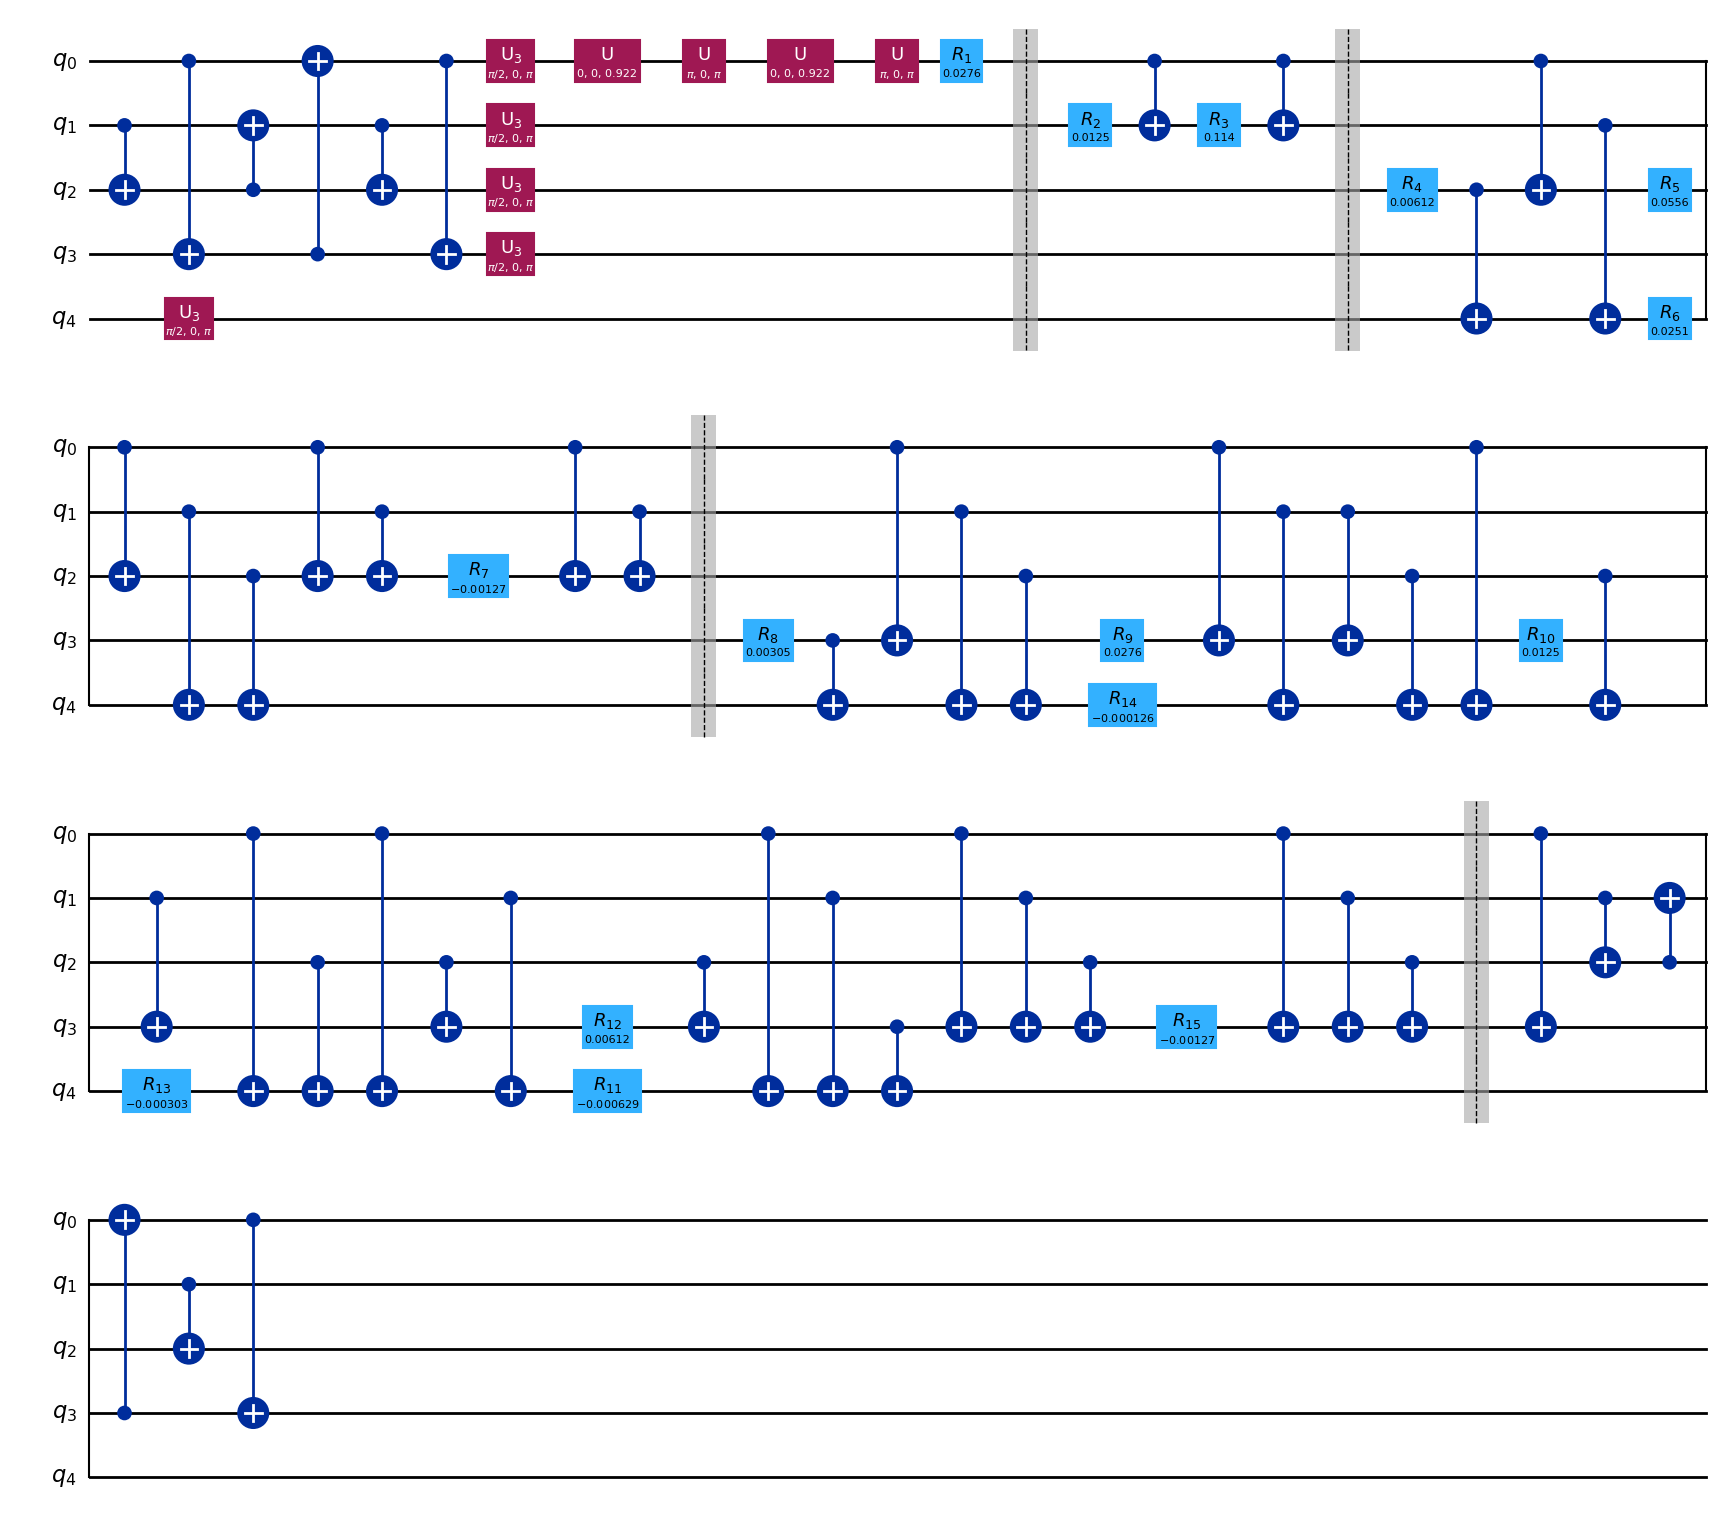

In [144]:
diag.decompose(reps=2).draw('mpl',style='iqx')

## Grey code

In [15]:
def walsh_grey(n,f,walsh_coeffs,start,end,gray_list):
    q = QuantumRegister(n,name='q')
    qc = QuantumCircuit(q)
    qubits = [qubit for qubit in q]
    for i in range(start,end):
        #print(i)
        decimal = binary_to_int(gray_list[i])
        if decimal == 1:
            qc.append(walsh_operator(decimal,walsh_coeffs),[qubits[0]])
        else:
            qc.append(walsh_operator(decimal,walsh_coeffs),qubits[:int(np.floor(np.log2(decimal)))+1])
    return qc

'''
n = 3
walsh_coeffs = list_walsh_coeff(f,2**n)
qc = walsh_grey(n,f,walsh_coeffs,1,2**n)
qc.decompose(reps=1).draw('mpl',style='iqx')
'''

def copy(reg1,reg2):
    """
    Parameters
    ----------
    reg1 : qiskit.circuit.quantumregister.QuantumRegister
        Register of qubits being copied
    reg2 : qiskit.circuit.quantumregister.QuantumRegister
        Register of qubits receving the copies
    
    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
        Quantum circuit whose first register copies its bit values into the second register
    """
    qc = QuantumCircuit(reg1,reg2)
    blocks = int(np.floor(reg2.size/reg1.size))
    ancilla_available = reg2.size
    for i in range(int(np.floor(np.log2(blocks)))+1):
        for j in range(2**i):
            if ancilla_available - reg1.size >= 0:
                for k in range(reg1.size):
                    if j == 0:
                        qc.cx(reg1[k],reg2[k + reg1.size*(2**i-1)])
                    elif k+reg1.size*(2**i-1)+reg1.size*j < reg2.size:
                        qc.cx(reg2[k+reg1.size*(j-1)],reg2[k+reg1.size*(2**i-1)+reg1.size*j])
                ancilla_available -= reg1.size
        #qc.barrier()
    return qc

def adjustable_walsh_grey(n,f,p,walsh_coeffs,gray_list):
    """
    Parameters
    ----------
    n : int
        Number of qubits
    f : function
        Function of one variable
    p : list
        Number of ancilla qubits, p >= n
    walsh_coeffs : list
        List of the Walsh coefficients

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
        Quantum circuit implementing the adjustable-depth Walsh circuit with Grey code
    """
    q = QuantumRegister(n,name='q')
    a = AncillaRegister(p,name='a')
    qc = QuantumCircuit(q,a)
    qubits = [i for i in q]+[i for i in a]
    ancillas = [k for k in a]
    #walsh_coeffs = list_walsh_coeff(f,2**n)
    
    for i in range(int(n/2)):
        qc.swap(q[i],q[n-i-1])
    qc.h(q)
    # order 0
    qc.p(walsh_coeffs[0],q[0])
    qc.x(q[0])
    qc.p(walsh_coeffs[0],q[0])
    qc.x(q[0])
    
    if p == 0: # no ancilla
        qc.append(walsh_grey(n,f,walsh_coeffs,1,2**n,gray_list),qubits)
    elif p >= n:
        #print('here')
        n_blocks = int(np.floor(p/n)+1)
        n_walsh_operator_per_block = int(np.floor((2**n-1)/(n_blocks)))
        n_walsh_operator_on_last_block = 2**n-1-n_walsh_operator_per_block*(n_blocks-1)
        copy_gate = copy(q,a)
        qc.append(copy_gate,qubits)
        #qc.barrier()
        #print('n_per_block=',n_walsh_operator_per_block)
        #print('n_on_last_block=',n_walsh_operator_on_last_block)
        
        for i in range(n_blocks):
            if i == 0:
                start = 1
                end = n_walsh_operator_on_last_block+1
                #print(start,end-1)
                qc.append(walsh_grey(n,f,walsh_coeffs,start,end,gray_list),[k for k in q])
            else:
                start = end
                end += n_walsh_operator_per_block
                #start = 1 + n_walsh_operator_on_last_block + (i-1)*n
                #end = start + n_walsh_operator_per_block + 1
                #print(start,end-1)
                #print((i-1)*n,n*i)
                qc.append(walsh_grey(n,f,walsh_coeffs,start,end,gray_list),ancillas[(i-1)*n:n*i])
        #qc.barrier()
        #'''
        qc.append(copy_gate.inverse(),qubits)
    else:
        print('p can not be smaller than n')
    for i in range(int(n/2)):
        qc.swap(q[i],q[n-i-1])
    return qc
'''
n = 4
p = 10
walsh_coeffs = list_walsh_coeff(f,2**n)
gray_list = generate_gray_list(n)
qc = adjustable_walsh_grey(n,f,p,walsh_coeffs,gray_list)
qc.decompose(reps=2).draw('mpl',style='iqx')
'''

"\nn = 4\np = 10\nwalsh_coeffs = list_walsh_coeff(f,2**n)\ngray_list = generate_gray_list(n)\nqc = adjustable_walsh_grey(n,f,p,walsh_coeffs,gray_list)\nqc.decompose(reps=2).draw('mpl',style='iqx')\n"

In [516]:
n = 4
p = 20 # p_max = n*(2**n-2) (resoudre p/n +1 = 2**n -1 i.e. nb block = nb walsh operator)
print('n_blocks=',int(np.floor(p/n))+1)
print('n_WO per block=',(2**n-1)/(np.floor(p/n)+1))
n_walsh_operator_per_block = int(np.floor((2**n-1)/(np.floor(p/n)+1)))
n_walsh_operator_on_last_block = int(2**n-1-(n_walsh_operator_per_block*(int(np.floor(p/n)))))
#print('p_max=',n*(2**n-2))
print('Sur les '+str(int(np.floor(p/n)))+' premiers blocks on met '+str(n_walsh_operator_per_block)+' Walsh operators')
print('Sur le dernier block on en met '+str(n_walsh_operator_on_last_block))
print('On a ainsi '+str(n_walsh_operator_per_block*int(np.floor(p/n))+n_walsh_operator_on_last_block)+' = '+str(2**n-1)+' Walsh operators au total')

n_blocks= 6
n_WO per block= 2.5
Sur les 5 premiers blocks on met 2 Walsh operators
Sur le dernier block on en met 5
On a ainsi 15 = 15 Walsh operators au total


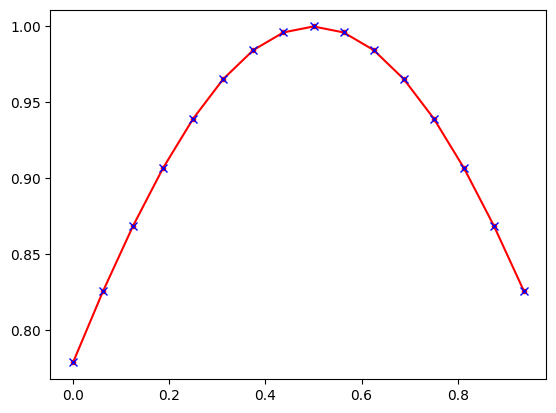

In [528]:
# test
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt

def f(x):
    return np.exp(-(x-1/2)**2)

n = 4
p = 10

diag = adjustable_walsh_grey(n,f,p)

state = qi.Statevector.from_instruction(diag)

L = np.array(state.data[0:2**n])
L2 = np.angle(L)
newL2 = reordering(L2,n,n)
X = np.array(range(2**n))/2**n

plt.plot(X,newL2,marker='.',c='r')
plt.plot(X,f(X),marker='x',c='b',linestyle='')
plt.show()

In [72]:
depth

[50]

In [77]:
# plots
n = 10
walsh_coeffs = [1 for i in range(2**n)]
gray_list = generate_gray_list(n)

depth = []
x = []
pmax = n*(2**n-2)
i = 0
for p in range(0,pmax+1,n):
    print(p)
    qc = adjustable_walsh_grey(n,f,p,walsh_coeffs,gray_list).decompose(reps=2)
    d = qc.depth()
    x.append(p)
    if p == 0:
        depth.append(d)
    if d <= depth[i-1]:
        #x.append(p)
        depth.append(d)
    else:
        depth.append(depth[i-1])
    i += 1

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [60]:
qc = adjustable_walsh_grey(n,f,n*(2**n-2),walsh_coeffs,gray_list).decompose(reps=2)
print(qc.depth())

50


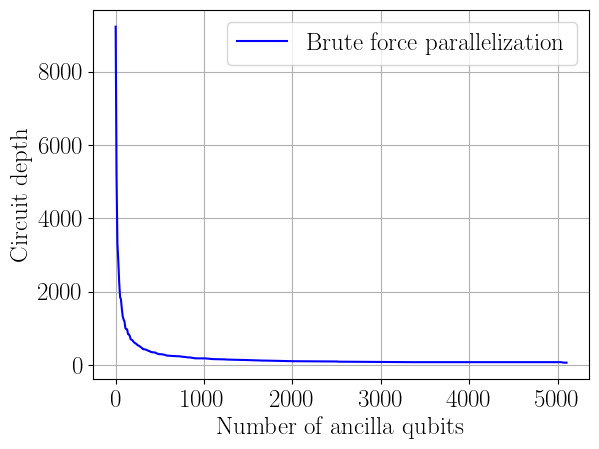

In [78]:
fig = plt.figure()
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "font.size": 18
})

plt.plot(x,depth,label='Brute force parallelization',color='blue')
#plt.plot(x,width,label='Width')
plt.xlabel('Number of ancilla qubits')
plt.ylabel('Circuit depth')
#plt.title('n = '+str(n))
plt.legend()
plt.grid()
plt.show()

In [79]:
depth

[9228,
 5130,
 3308,
 2826,
 2255,
 1851,
 1789,
 1530,
 1324,
 1241,
 1188,
 1006,
 979,
 972,
 843,
 838,
 787,
 703,
 676,
 639,
 595,
 583,
 561,
 538,
 528,
 517,
 492,
 481,
 432,
 432,
 420,
 413,
 385,
 385,
 353,
 353,
 346,
 346,
 341,
 341,
 320,
 314,
 295,
 295,
 294,
 284,
 283,
 256,
 256,
 244,
 244,
 239,
 239,
 239,
 224,
 224,
 207,
 207,
 207,
 182,
 182,
 182,
 181,
 181,
 181,
 162,
 160,
 160,
 154,
 149,
 149,
 138,
 138,
 138,
 121,
 121,
 121,
 104,
 104,
 104,
 96,
 91,
 91,
 91,
 78,
 78,
 78,
 78,
 78,
 78,
 74,
 66,
 65,
 65,
 65,
 65]

In [76]:
fig.savefig('1000.png', dpi=1000, bbox_inches='tight')

In [55]:
min(depth)

121

In [67]:
array = [int(i) for i in np.logspace(0,np.log10(10*(1022)),21)]
array

[1,
 1,
 2,
 3,
 6,
 10,
 15,
 25,
 40,
 63,
 101,
 160,
 254,
 403,
 640,
 1016,
 1612,
 2558,
 4059,
 6441,
 10220]